# Seating optimization

This notebook is an implementation of a simple stochastic algorithm to find a (quasi-) optimal solution for assigning guests to tables at events like weddings. It assumes that every pair of guests as a certain "favorability" score based on how well (or poorly) they can be expected to get along. It assigns each guest to a table with the goal of maximizing the total favorability of guests sitting at the same table. This problem is **very** computationally hard to solve exactly for any non-trivial number of guests, but even a very naive, simple optimization algorithm does a pretty good job, pretty quickly.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

### Importing guests

First, we need to import the list of guest names at the wedding. I've used as a default a list of 23 guests. If you want to use your own list, edit `sample_names.csv` putting one name in each row, or use a csv in similar format, replacing the reference to the file name below.

In [2]:
names = pd.read_csv("sample_names.csv")
display(names)

,Name
0,Alice
1,Bob
2,Charlie
3,David
4,Eliza
5,Frank
6,Greg
7,Heather
8,Igor
9,Jack


What we care about, though, is the interactions _between_ each pair of guests. We can visualize that by rearranging the guest list into an upper triangular matrix.

In [3]:
pairs = pd.DataFrame(0.0,index=names.values[:,0],columns=names.values[:,0])
pairs = pairs.where(np.triu(np.ones(pairs.shape),1).astype(np.bool))
display(pairs)

,Alice,Bob,Charlie,David,Eliza,Frank,Greg,Heather,Igor,Jack,...,Nancy,Oscar,Peter,Quentin,Rose,Steve,Tom,Ulysses,Veronica,Walter
Alice,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bob,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Charlie,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
David,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eliza,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frank,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Greg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heather,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Igor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Entering pairwise scores between guests

In order to actually enter in and process this data, though, it can be helpful to "unstack" these pairs into list form. Below, I turn the pairs into a list and save it to `pairs.csv`, which can be edited in order to enter in the suitability of each pair of guests.

In [4]:
pairs = pairs.stack().reset_index()
pairs.columns = ['Person1','Person2','Suitability']
display(pairs)
pairs.to_csv('pairs.csv')

,Person1,Person2,Suitability
0,Alice,Bob,0.0
1,Alice,Charlie,0.0
2,Alice,David,0.0
3,Alice,Eliza,0.0
4,Alice,Frank,0.0
5,Alice,Greg,0.0
6,Alice,Heather,0.0
7,Alice,Igor,0.0
8,Alice,Jack,0.0
9,Alice,Kelly,0.0


After you've entered in as many pairwise suitability scores as you want, you can read the data back in. I've also given the option of randomly generating some suitability scores, with some couples that should be seated together, some people who (due presumably to sordid history) should not sit together, and the remaining pairs mildly positive or negative.

In [5]:
newpairs = pd.read_csv('pairs.csv',index_col=0)

# COMMENT OUT THESE NEXT THREE LINES IF YOU'VE ENTERED IN YOUR OWN SCORES
newpairs['Suitability'] = np.random.uniform(-0.2,0.2,size=newpairs['Suitability'].size)
newpairs.loc[newpairs.sample(n=(names.size/4)).index,'Suitability'] = 1
newpairs.loc[newpairs.sample(n=(names.size/10)).index,'Suitability'] = -1
#

costMatrix = newpairs.set_index(['Person1', 'Person2']).unstack()
display(costMatrix)
costMatrix = costMatrix.values

Suitability                                                    \
Person2          Bob   Charlie     David     Eliza     Frank      Greg   
Person1                                                                  
Alice      -0.114089  0.019406  0.089194 -0.170023 -0.077881 -0.011981   
Bob              NaN -0.082149  0.048380 -0.020777 -0.134237 -0.186346   
Charlie          NaN       NaN -0.191490 -0.177296  0.040437 -0.172625   
David            NaN       NaN       NaN -0.071829 -0.099608 -0.039222   
Eliza            NaN       NaN       NaN       NaN -0.184795 -0.169609   
Frank            NaN       NaN       NaN       NaN       NaN -0.182339   
Greg             NaN       NaN       NaN       NaN       NaN       NaN   
Heather          NaN       NaN       NaN       NaN       NaN       NaN   
Igor             NaN       NaN       NaN       NaN       NaN       NaN   
Jack             NaN       NaN       NaN       NaN       NaN       NaN   
Kelly            NaN       NaN       NaN       NaN       NaN       NaN   
Larry            NaN       NaN       NaN       NaN       NaN       NaN   
Mary             NaN       NaN       NaN       NaN       NaN       NaN   
Nancy            NaN       NaN       NaN       NaN       NaN       NaN   
Oscar            NaN       NaN       NaN       NaN       NaN       NaN   
Peter            NaN       NaN       NaN       NaN       NaN       NaN   
Quentin          NaN       NaN       NaN       NaN       NaN       NaN   
Rose             NaN       NaN       NaN       NaN       NaN       NaN   
Steve            NaN       NaN       NaN       NaN       NaN       NaN   
Tom              NaN       NaN       NaN       NaN       NaN       NaN   
Ulysses          NaN       NaN       NaN       NaN       NaN       NaN   
Veronica         NaN       NaN       NaN       NaN       NaN       NaN   

                                                    ...               \
Person2    Heather      Igor      Jack     Kelly    ...        Nancy   
Person1                                             ...                
Alice    -0.083884 -0.006446 -0.011345  0.098017    ...     0.028876   
Bob       0.024495 -0.197957  0.083953 -0.132722    ...     0.027147   
Charlie  -0.038822 -0.035075 -0.144722  0.193648    ...     0.154072   
David     0.179437 -0.079133 -0.020114  0.085202    ...    -0.192096   
Eliza     0.008277 -0.194782 -0.006240  0.138911    ...     0.062452   
Frank    -0.019071 -0.158628 -0.173307  0.169434    ...     0.063059   
Greg     -0.024250  0.046065  0.177162  0.007440    ...    -0.002082   
Heather        NaN -0.116844  0.177297  0.073148    ...    -0.166857   
Igor           NaN       NaN  0.086679  0.184793    ...    -1.000000   
Jack           NaN       NaN       NaN  0.131577    ...    -0.074157   
Kelly          NaN       NaN       NaN       NaN    ...     0.168512   
Larry          NaN       NaN       NaN       NaN    ...     0.112099   
Mary           NaN       NaN       NaN       NaN    ...    -0.116321   
Nancy          NaN       NaN       NaN       NaN    ...          NaN   
Oscar          NaN       NaN       NaN       NaN    ...          NaN   
Peter          NaN       NaN       NaN       NaN    ...          NaN   
Quentin        NaN       NaN       NaN       NaN    ...          NaN   
Rose           NaN       NaN       NaN       NaN    ...          NaN   
Steve          NaN       NaN       NaN       NaN    ...          NaN   
Tom            NaN       NaN       NaN       NaN    ...          NaN   
Ulysses        NaN       NaN       NaN       NaN    ...          NaN   
Veronica       NaN       NaN       NaN       NaN    ...          NaN   

                                                                      \
Person2      Oscar     Peter   Quentin      Rose     Steve       Tom   
Person1                                                                
Alice     0.142493 -0.113485  0.058524  0.054512  0.134104  0.025751   
Bob      -0.126778 -0.128891  0.115695 -0.057443  0.168372 -0.139231 

### Setting up the optimization problem

In order to set up the problem, we need to define the number of tables and the maximum number of guests for each (for simplicity, I'm assuming all tables are the same size). Here, we assume 5 tables of 5 people for 23 guests, meaning that two table spots are left empty. These are filled with empty chairs.

In [6]:

nTables = 5
tableSize = 5


nEmptyChairs = nTables*tableSize - names.size
allNames = names.copy()
for i in range(names.size,nTables*tableSize):
    allNames.loc[i] = "Empty Chair" 
fullCostMatrix = np.pad(costMatrix,((0,nEmptyChairs+1),(1,nEmptyChairs)), mode='constant', constant_values=0)
allNames['Table']=np.random.permutation(np.arange(allNames.size)/tableSize)
display(allNames)

,Name,Table
0,Alice,0
1,Bob,4
2,Charlie,1
3,David,2
4,Eliza,1
5,Frank,1
6,Greg,1
7,Heather,4
8,Igor,1
9,Jack,3


### Python stuff

To set this up, let's define a few data structures. First, `setup_details` is a dictionary that contains the pairwise suitability scores for guests, in matrix form, and info on the number of tables and table size. It is not totally necessary, but it keeps things in the same place and means fewer objects need to be passed to and from functions. 

Second, we define a class called `arrangement` that defines a possible arrangement of guests. Along with info from `setup_details`, an `arrangement` also contains:
* A list of guest names
* An array of table assignments
* The arrangement's current suitability score
* The suitability score on the previous iteration (for plotting)

The class `arrangement` also has a set of methods that act on itself and are used during the optimization process. An arrangement can:
* Initialize a random arrangement of table assignments
* Calculate the favorability score of its current arrangement
* Randomly swap two guests between tables
* Adopt the table assignments and suitability score of a different `arrangement` object. This is helpful so that we don't need to fully copy the entire object in memory when resetting a table arrangement that is not used.

A benefit of not using an exact solution algorithm is that we have a little bit more flexibility in both the way we store the data and the exact objective function we use. For example, most exact solutions to this problem would need to store information about a solution in a `nGuests * nTables` binary matrix that is true when a certain guest is at a certain table and false otherwise. This works fine, but is an additional step of abstraction away from the way I think about table arrangements, making it less clear and more of a pain to enter in all relevant constraints. Here, we can just store the arrangement as a `nGuests` long list of table assignments (including empty chairs) and try new solutions by just rearranging this list, meaning that we don't explicitly have to deal with the constraints that each table can only hold a certain number of people or that each person must sit at exactly one table. If we used a standard IP solver, we would have to enter in each of those constraints individually.

As for the objective function, here I still use the simple goal of maximizing the total suitability over all pairs of people sitting at the same table. But, one takeaway from planning a wedding seating arrangement in practice is that other factors might come into play as well. For example, this algorithm can produce un-equitable solutions where, for example, one member of a group of friends is "sacrificed" to a separate table in order to maximize the happiness of the remaining group. This algorithm allows for non-linear formulations of the objective function that could in theory account for these effects in determining the quality of a solution--the only practical concern is that the objective function should remain relatively efficient to compute. 

Here I calculate the objective function using the numpy `meshgrid` function (a trick stolen from Matlab) which outputs two square matrices, one where each column is the table ID of the guest associated with that column, one that is similar but for each row. The cells where these two matrices are equal correspond to pairs of guests who are at the same table and therefore whose suitability score (stored in a matrix of the same shape) is relevant to the quality of the solution. These are then filtered to only the upper triangular part of the matrix, to avoid double counting and unnecessary addition. I'm not sure if this is the most efficient way (it's based on a solution that tends to work well in Matlab, but I'm not sure how well it carries over to Numpy), so I'd welcome suggestions to speed it up.

In [7]:
setup_details = dict(costs = fullCostMatrix, nTables = nTables, tableSize = tableSize)
class arrangement:
    def __init__(self,guests,setup_details):
        self.guests = guests
        self.costs = setup_details["costs"]
        self.nTables = setup_details["nTables"]
        self.tableSize = setup_details["tableSize"]
        self.favorability = np.nan
        self.previous_favorability = np.nan
        self.randomize_tables()
    def randomize_tables(self):
        self.tables = np.random.permutation(np.arange(self.guests.size)/self.tableSize)
        self.calculate_favorability()
    def calculate_favorability(self):
        xv, yv = np.meshgrid(self.tables, self.tables)
        self.favorability = np.nansum(self.costs[(xv == yv)*(np.triu(np.ones(self.costs.shape,dtype=bool),1))])
    def randomly_swap(self):
        keepGoing = True
        while keepGoing:
            inds = np.random.choice(self.guests.size, 2, replace=False)
            if self.tables[inds[0]] != self.tables[inds[1]]:
                keepGoing = False
        temp = self.tables[inds[0]].copy()
        self.tables[inds[0]] = self.tables[inds[1]].copy()
        self.tables[inds[1]] = temp
        self.calculate_favorability()
    def adopt_new_arrangement(self,arrangement):
        self.tables = arrangement.tables.copy()
        self.favorability = arrangement.favorability.copy()

We can also define a few external functions that are used in the optimization process. Basically, what we are going to do is start with a random seating arrangement and keep swapping guests between tables, accepting a trial swap if it improves the total suitability score and _probably_ not accepting it if it doesn't. The precise *acceptance function* determines whether or not a new trial arrangement is accepted or discarded.

* The *simple* acceptance function only adopts a trial arrangement if it scores better than the current arrangement. This is a _greedy_ algorithm.
* The *annealing* acceptance function always accepts an arrangement if it scores better than the current arrangement, but it also sometimes accepts arrangements that score worse. This is a probabalistic process, and accepting a worse-scoring trial arrangement gets less likely 1) if the trial arrangement scores _far_ worse and 2) as time goes on. 

In *simulated annealing*, we transition from exploring the possible solution space at the beginning of the simulation to finding a local minimum towards the end of the simulation. This transition is governed by a parameter defined as *temperature*, in analogy to an actual annealing process used to strengthen metals. This temperature cools as time goes on, and the lower the temperature the less likely the solution is to hop out of a local minimum (or, in this case, accept a trial arrangement that scores worse than the current arrangement).

In [8]:
def simple_acceptance_function(cost1,cost2,temperature):
    if cost2 > cost1:
        return True
    else:
        return False
    
def annealing_acceptance_function(cost1,cost2,temperature):
    a = np.exp((cost2 - cost1)/temperature)
    if a >= 1:
        return True
    else:
        return np.random.random_sample() < a

def iterate(arr1,arr2,temperature):
    arr1.previous_favorability = arr1.favorability
    swap = annealing_acceptance_function(arr1.favorability,arr2.favorability,temperature)
    if swap:
        arr1.adopt_new_arrangement(arr2)
    else:
        arr2.adopt_new_arrangement(arr1)
    arr2.randomly_swap()

### Initialize the optimization

To actually implement this, we create three `arrangement` objects. **arr_current** is the current solution, **arr_test** keeps a trial solution that we are evaluating, and **arr_best** keeps track of the best-performing solution we have yet found. In simulated annealing, the current solution almost always ends up back at the best-performing solution, but this is not totally guaranteed.

We start off by setting all three of these arrangements to be the same, then we randomly swap two guests in **arr_test**.

In [9]:
arr_current = arrangement(allNames["Name"].values,setup_details)
arr_test = arrangement(allNames["Name"].values,setup_details)
arr_best = arrangement(allNames["Name"].values,setup_details)
arr_test.adopt_new_arrangement(arr_current)
arr_best.adopt_new_arrangement(arr_current)
arr_test.randomly_swap()

### Iterate!

Here, the iteration process is very simple. Given a current arrangement and a trial arrangement, each step we:

1. Calculate favorability scores for current and trial arrangement
2. Use our acceptance function to determine whether to adopt the trial arrangement
3. If we do accept, adopt the test arrangement in **arr_current**. If not, we reset the arrangement in **arr_test** to match the current arrangement.
4. Randomly swap two guests in **arr_test**.

This process repeats until there has been a long time since the last improvement. The free parameters are the starting temperature and the number of iterations without improvement before the algorithm stops.

So that we can plot solutions, we also keep track of a few quantities in external arrays. Every time the algorithm accepts a new solution, we keep track of the iteration number, the current solution, and the best solution we have seen.

/Users/zneedell/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/zneedell/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


<IPython.core.display.Javascript object>


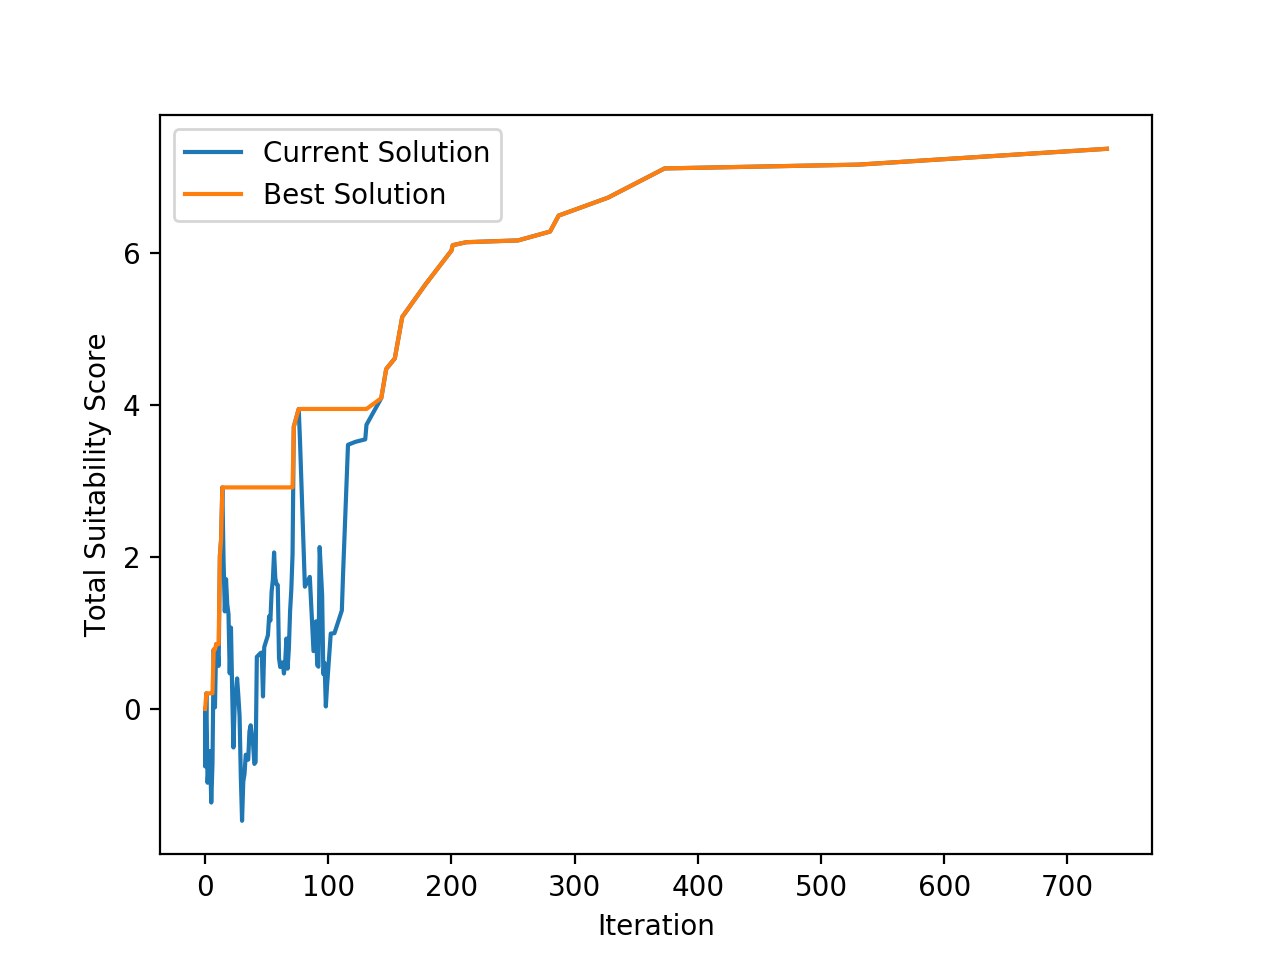

Text(0,0.5,u'Total Suitability Score')

In [10]:
time = np.zeros([1],int)
current_solution = np.zeros([1],float)
best_solution = np.zeros([1],float)
for i in range(200000):
    temperature = 100/(i+1)
    iterate(arr_current,arr_test,temperature)
    if arr_current.previous_favorability != arr_current.favorability:
        time = np.append(time,i)
        current_solution = np.append(current_solution,arr_current.favorability)
        if arr_current.favorability > best_solution[-1]:
            arr_best.adopt_new_arrangement(arr_current)
        best_solution = np.append(best_solution,max(arr_current.favorability,best_solution[-1]))
    if (i - time[-1]) > 20000:
        break
plt.plot(time,current_solution,label='Current Solution')
plt.plot(time,best_solution,label='Best Solution')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Total Suitability Score')

After the algorithm as stopped, we can look at the (quasi-) optimal solution.

In [11]:
df = pd.DataFrame(arr_best.guests,columns = ['Name'])
df["Table"] = np.apply_along_axis(lambda y: ["Table " + str(i+1) for i in y], 0, arr_best.tables)
newdf = pd.DataFrame()
for key, values in df.groupby("Table").groups.iteritems():
    newdf[key] = df["Name"].loc[values].values
newdf = newdf.reindex(sorted(newdf.columns), axis=1)
display(newdf)

,Table 1,Table 2,Table 3,Table 4,Table 5
0,Greg,Heather,Eliza,Alice,Bob
1,Igor,Larry,Jack,Charlie,David
2,Mary,Ulysses,Oscar,Frank,Quentin
3,Steve,Walter,Peter,Kelly,Rose
4,Empty Chair,Empty Chair,Tom,Nancy,Veronica
